In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [4]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [5]:
y.index = y.name

In [6]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [7]:
y.index = pd.to_datetime(y.index)

In [8]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

In [9]:
y

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [10]:
from pytrends.request import TrendReq

In [11]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["iPhone", "Recession", "Samsung", "Interest Rates", "New Phone", "Buy iPhone", "Taylor Swift Tickets", "Hospital", "UCLA"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [12]:
df = df.resample("Q").mean()

In [13]:
# ALIGN DATA
temp = pd.concat([y, df],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()
temp

,BasicEPS,iPhone,Recession,Samsung,Interest Rates,New Phone,Buy iPhone,Taylor Swift Tickets,Hospital,UCLA
2004-03-31,0.002,0.000000,7.333333,24.666667,60.000000,44.333333,0.000000,0.000000,77.333333,85.333333
2004-06-30,0.003,0.000000,7.666667,24.000000,66.333333,46.333333,0.000000,0.000000,75.666667,84.333333
2004-09-30,0.0,0.000000,6.000000,26.666667,52.666667,47.666667,0.000000,0.000000,79.666667,76.333333
2004-12-31,0.013,0.000000,7.333333,30.000000,46.000000,43.333333,0.333333,0.000000,73.666667,84.333333
2005-03-31,0.013,0.000000,5.666667,26.333333,47.000000,40.666667,0.000000,0.000000,78.666667,80.333333
...,...,...,...,...,...,...,...,...,...,...
2022-09-30,1.29,51.666667,56.333333,58.333333,77.000000,90.000000,32.333333,0.666667,86.000000,31.000000
2022-12-31,1.89,49.000000,49.000000,60.666667,78.333333,73.666667,31.333333,37.000000,76.000000,41.666667
2023-03-31,1.53,49.666667,36.666667,55.666667,88.000000,74.333333,25.000000,13.333333,81.666667,43.000000
2023-06-30,1.27,43.666667,29.000000,53.000000,74.000000,69.333333,22.000000,53.000000,79.666667,29.333333


# 3.) Normalize all the X data

In [14]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
X_scaled = scaler.fit_transform(df)

In [18]:
X_scaled

array([[-1.85788178e+00, -7.68923221e-01, -1.73700020e+00,
         9.80714673e-01, -9.28482259e-01, -1.78283882e+00,
        -4.66009433e-01,  4.13266560e-01,  1.95532403e+00],
       [-1.85788178e+00, -7.48877266e-01, -1.77289230e+00,
         1.46016826e+00, -7.99629496e-01, -1.78283882e+00,
        -4.66009433e-01,  1.48854306e-01,  1.89601261e+00],
       [-1.85788178e+00, -8.49107039e-01, -1.62932391e+00,
         4.25557892e-01, -7.13727653e-01, -1.78283882e+00,
        -4.66009433e-01,  7.83443716e-01,  1.42152130e+00],
       [-1.85788178e+00, -7.68923221e-01, -1.44986343e+00,
        -7.91300912e-02, -9.92908641e-01, -1.76232604e+00,
        -4.66009433e-01, -1.68440399e-01,  1.89601261e+00],
       [-1.85788178e+00, -8.69152994e-01, -1.64726996e+00,
        -3.42689371e-03, -1.16471233e+00, -1.78283882e+00,
        -4.66009433e-01,  6.24796363e-01,  1.65876696e+00],
       [-1.85788178e+00, -8.29061084e-01, -1.66521601e+00,
        -3.42689371e-03, -1.27208963e+00, -1.782838

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [19]:
from sklearn.linear_model import Lasso

In [20]:
lasso = Lasso(alpha=0.1)
lasso = lasso.fit(X_scaled[:-2],y)

In [21]:
coefficients = lasso.coef_ 

In [22]:
coefficients

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.28145666,
        0.        ,  0.02624645,  0.        , -0.04021217])

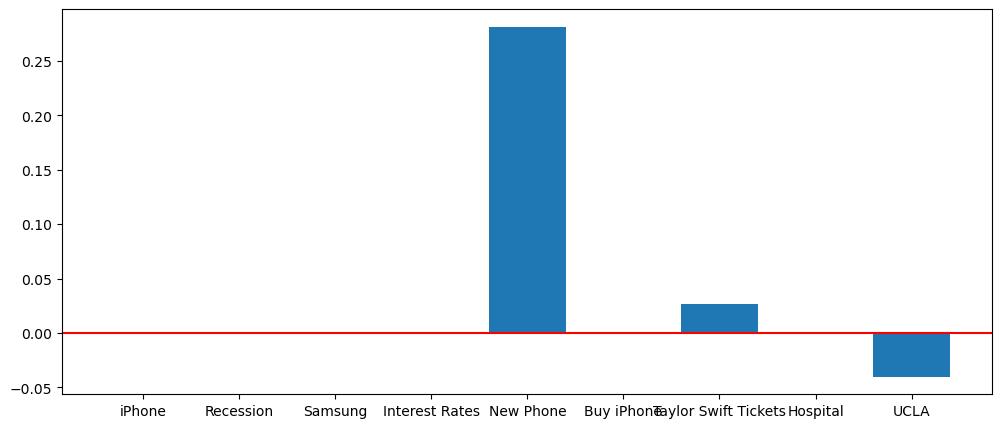

In [23]:
plt.figure(figsize = (12,5))
plt.bar(X.columns, coefficients)
plt.axhline(0, color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?